# Finding fast growing firms
## Murat Tirkeshov

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Data
### Data cleaning

In [2]:
data = pd.read_csv("cs_bisnode_panel.csv")
# data = pd.read_csv("https://osf.io/download/3qyut/")

In [3]:
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages", "D"]
)
data = data.query("year !=2016")

In [4]:
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [5]:
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)

In [6]:
data = data.query("year <= 2014")
data = data.query("year >= 2011")

In [7]:
alive_2012 = data.loc[(data.year == 2012) & (data.status_alive == 1), 'comp_id'].unique()
data = data[data.comp_id.isin(alive_2012)]

In [8]:
# Filter the data to only include records for 2013 and 2014
sales_data = data[data['year'].isin([2013, 2014])]

# Pivot the data so that each company has its sales for 2013 and 2014 in separate columns
sales_pivot = sales_data.pivot(index='comp_id', columns='year', values='sales').reset_index()

# Rename the columns for clarity
sales_pivot.rename(columns={2013: 'sales_2013', 2014: 'sales_2014'}, inplace=True)

# Optionally, merge the pivoted sales back into your main dataset if needed
data = data.merge(sales_pivot, on='comp_id', how='left')

In [9]:
# Calculate the two-year growth rate using sales_2012 as baseline and sales_2014
data['growth_rate'] = (data['sales_2014'] - data['sales']) / data['sales']

# Determine the 75th percentile threshold for the growth rate


In [10]:
data['growth_rate'].describe(percentiles=[.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95])

count    7.457100e+04
mean              NaN
std               NaN
min              -inf
5%      -1.000000e+00
10%     -7.316712e-01
15%     -4.521456e-01
20%     -2.745839e-01
25%     -1.469774e-01
30%     -4.991671e-02
35%      0.000000e+00
40%      0.000000e+00
45%      0.000000e+00
50%      0.000000e+00
55%      0.000000e+00
60%      3.322934e-02
65%      1.030489e-01
70%      1.843371e-01
75%      2.868400e-01
80%      4.359372e-01
85%      6.832502e-01
90%      1.232082e+00
95%      3.729802e+00
max               inf
Name: growth_rate, dtype: float64

In [11]:
threshold = data['growth_rate'].quantile(0.75)

# Create the fast growth dummy variable: 1 if growth_rate is above the threshold, 0 otherwise
data['fast_growth'] = (data['growth_rate'] > threshold).astype(int)

# Optional: Display the first few rows to verify the results
print(data[['sales', 'sales_2014', 'growth_rate', 'fast_growth']].head())

           sales     sales_2014  growth_rate  fast_growth
0       0.000000    4888.888672          inf            1
1  573222.250000  216751.859375    -0.621871            0
2   11577.777344            NaN          NaN            0
3  393292.593750  472859.250000     0.202309            0
4  170466.671875  101051.851562    -0.407205            0


In [12]:
data["sales"].describe()

count    8.441700e+04
mean     5.707577e+05
std      4.053280e+06
min     -6.072593e+04
25%      1.225185e+04
50%      4.203704e+04
75%      1.423296e+05
max      1.099510e+08
Name: sales, dtype: float64

In [13]:
to_filter=data.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

exit_year               85053
exit_date               84222
labor_avg               25217
birth_year              23958
growth_rate             16809
founded_year            13634
inoffice_days           13629
female                  13629
origin                  13629
gender                  13629
ceo_count               13629
foreign                 13629
sales_2014              12412
ind                      9182
amort                    7135
personnel_exp            7135
material_exp             7135
sales_2013               7052
sales                    6963
extra_inc                6963
inc_bef_tax              6963
extra_profit_loss        6963
extra_exp                6963
region_m                 6816
nace_main                6590
ind2                     6590
tang_assets              6589
share_eq                 6589
profit_loss_year         6589
liq_assets               6589
inventories              6589
intang_assets            6589
fixed_assets             6589
curr_liab 

### Creating new variables

In [14]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [15]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [16]:
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [17]:
data["labor_avg_mod"].describe()

count    91380.000000
mean         1.045567
std          4.102967
min          0.083333
25%          0.166667
50%          0.462121
75%          1.045567
max        202.106064
Name: labor_avg_mod, dtype: float64

In [18]:
data = data.drop(["labor_avg"], axis=1)

In [19]:
data = data.query("year==2012")

In [20]:
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [21]:
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [22]:
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    22821
1.0       14
Name: comp_id, dtype: int64

In [23]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [24]:
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.283500e+04
mean     5.233946e+05
std      5.523226e+06
min      0.000000e+00
25%      5.918519e+03
50%      2.281852e+04
75%      9.340185e+04
max      4.918527e+08
Name: total_assets_bs, dtype: float64

In [25]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [26]:
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [27]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [28]:
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [29]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [30]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [31]:
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [32]:
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["fast_growth_f"] = data["fast_growth"].astype("category")  
data["fast_growth_f"] = data["fast_growth_f"].cat.rename_categories(["no_fast_growth", "fast_growth"])  

In [33]:
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

In [34]:
to_filter=data.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

exit_year         20560
exit_date         20286
birth_year         5365
sales_2014         3103
growth_rate        3103
                  ...  
curr_assets_bs       10
share_eq_bs          10
ind2                  6
nace_main             6
founded_date          3
Length: 70, dtype: int64

### Data visualisation

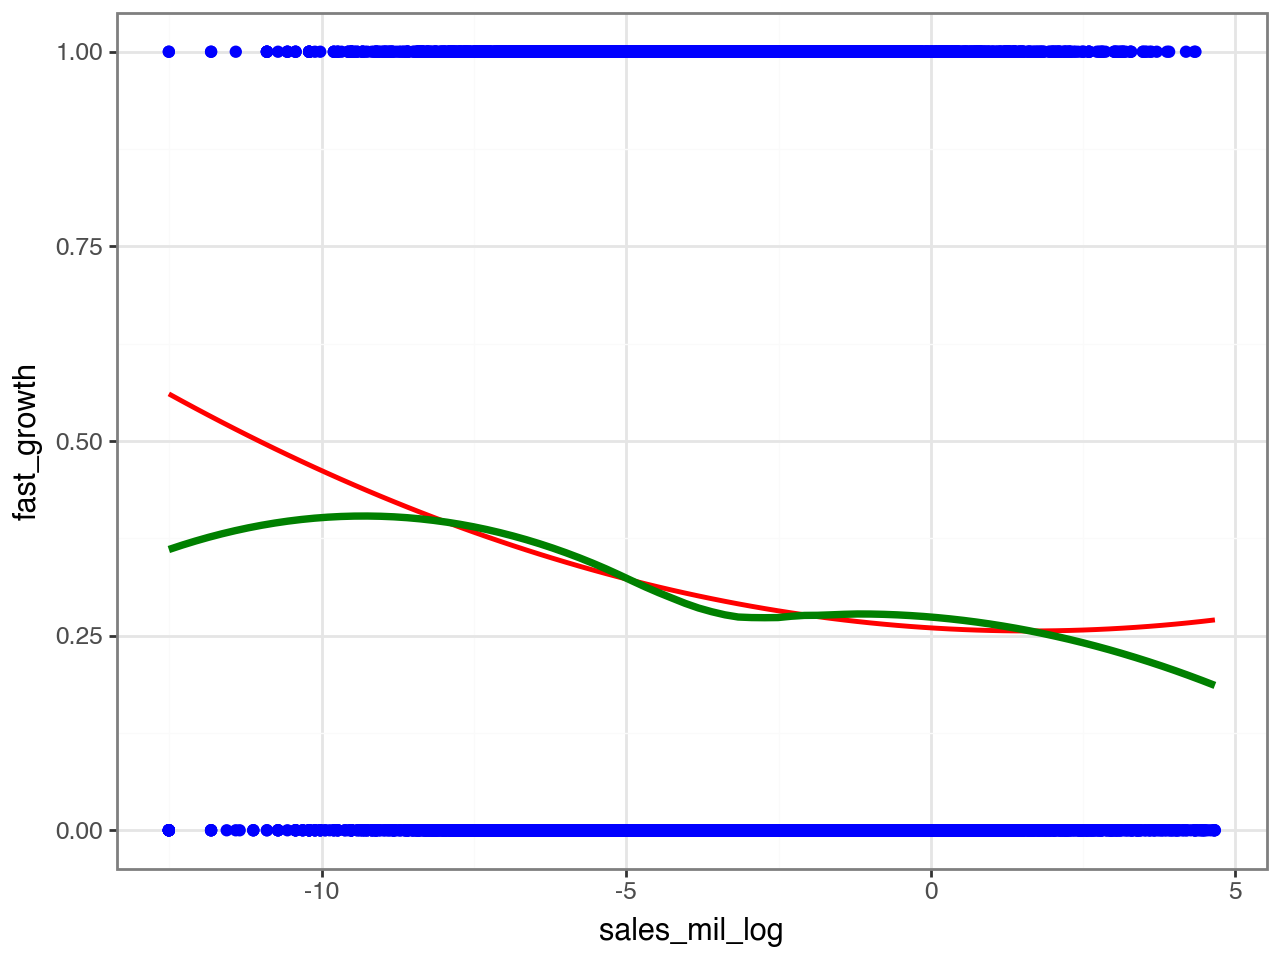

In [35]:
from plotnine import ggplot, aes, geom_point, labs, scale_x_continuous, scale_y_continuous, theme_bw, geom_smooth
color = ['blue', 'red', 'green']

plot = (
    ggplot(data, aes(x="sales_mil_log", y="fast_growth"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="fast_growth")
    + theme_bw()
)

print(plot)

In [36]:
ols_s = smf.ols("fast_growth ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     58.05
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           7.11e-26
Time:                        21:26:32   Log-Likelihood:                -14495.
No. Observations:               22845   AIC:                         2.900e+04
Df Residuals:                   22842   BIC:                         2.902e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2600      0.006  

In [37]:
data["d1_sales_mil_log"].describe()


count    22845.000000
mean        -0.129744
std          1.006222
min        -12.506177
25%         -0.167302
50%          0.000000
75%          0.095806
max          8.522544
Name: d1_sales_mil_log, dtype: float64

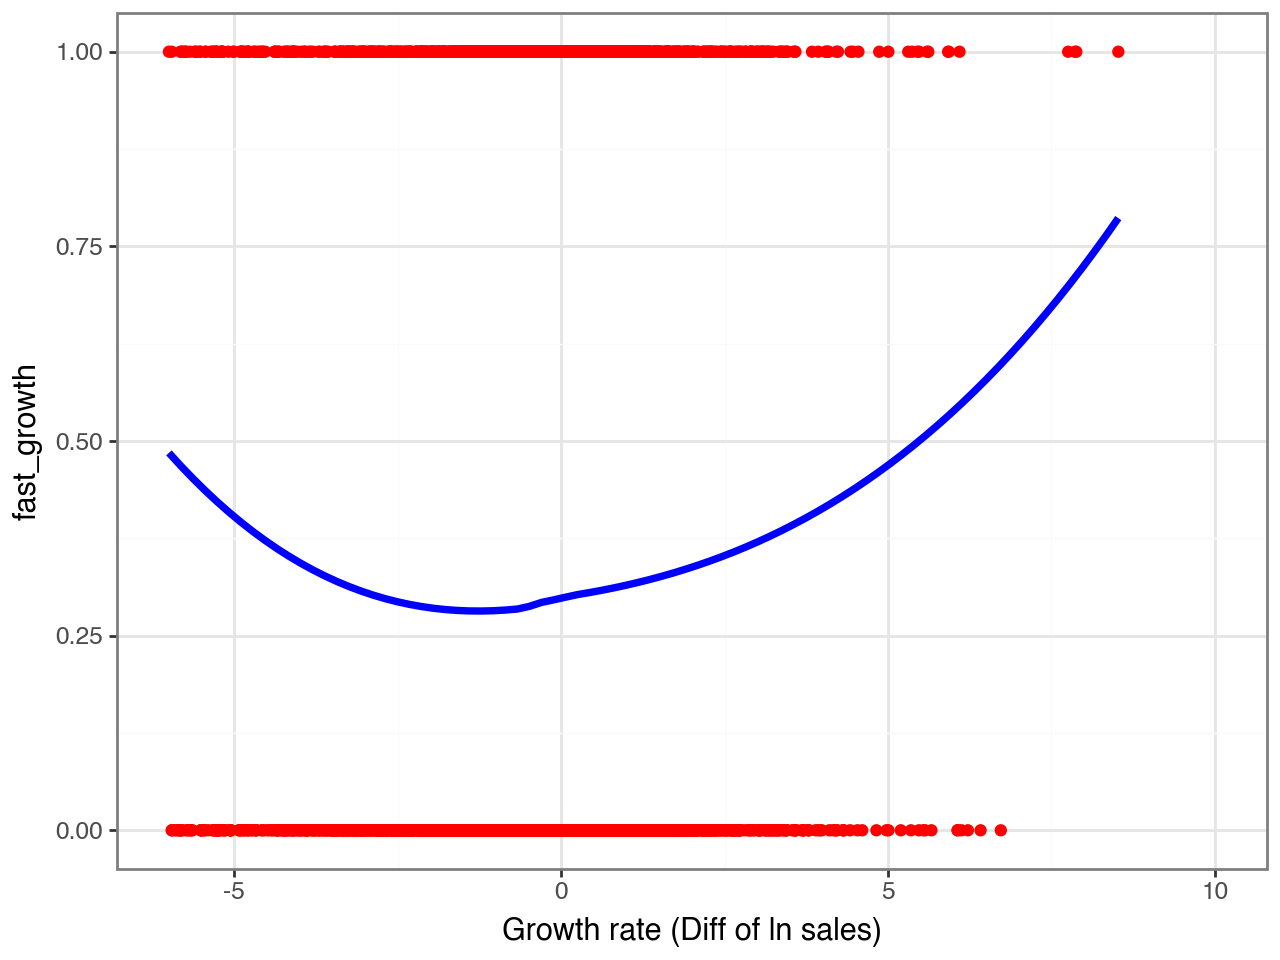

In [38]:
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, scale_x_continuous, theme_bw
(
    ggplot(data, aes(x="d1_sales_mil_log", y="fast_growth"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast_growth")
    + scale_x_continuous(limits=(-6, 10), breaks=range(-5, 11, 5))
    + theme_bw()
)

In [39]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [40]:
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [41]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    19942.000000
mean         8.705747
std          6.939425
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

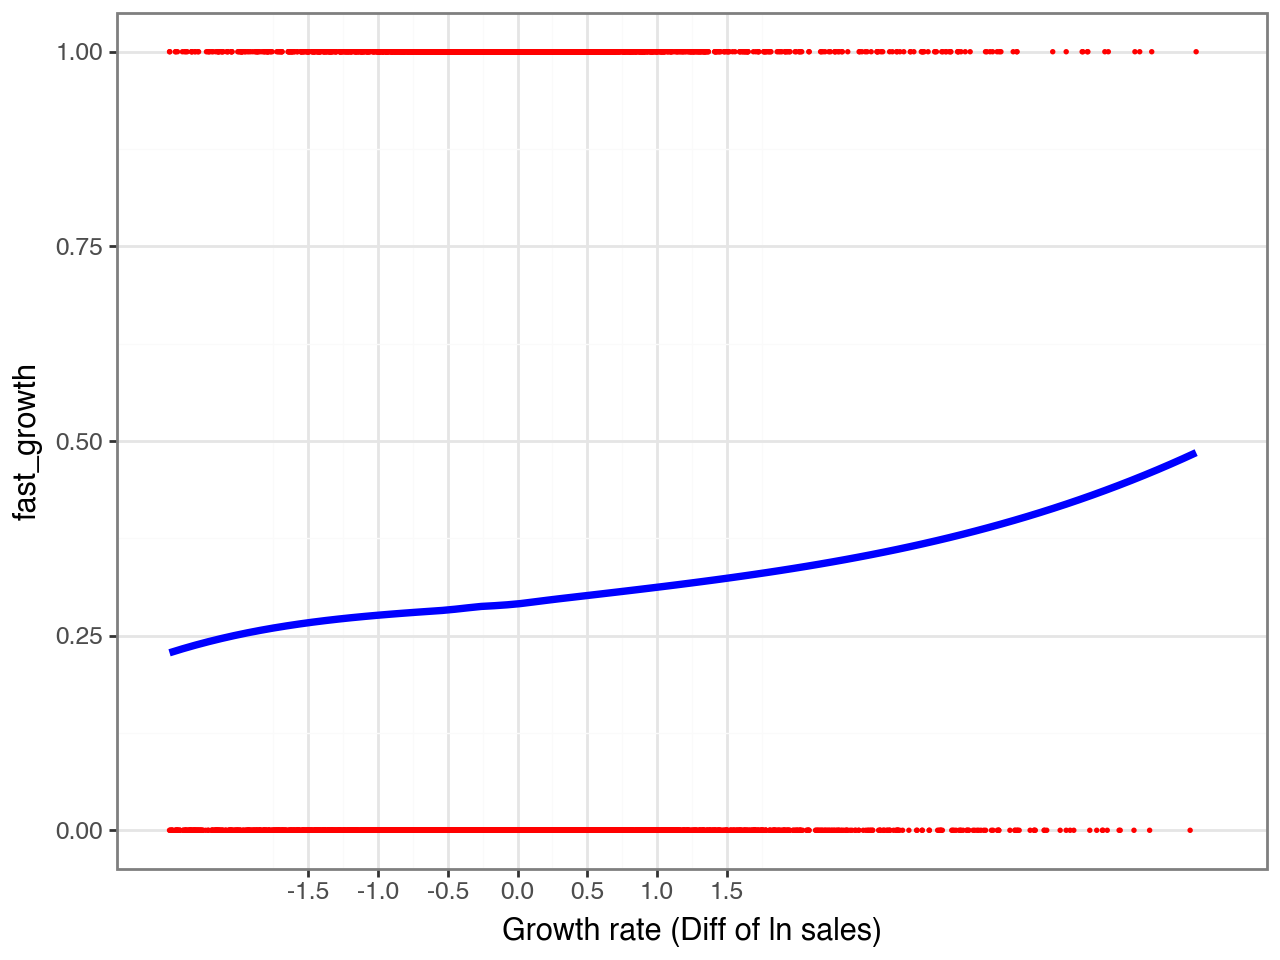

In [42]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="fast_growth"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast_growth")
    + scale_x_continuous(limits=(-2.5, 5), breaks=np.arange(-1.5, 1.6, 0.5))
    + theme_bw()
)

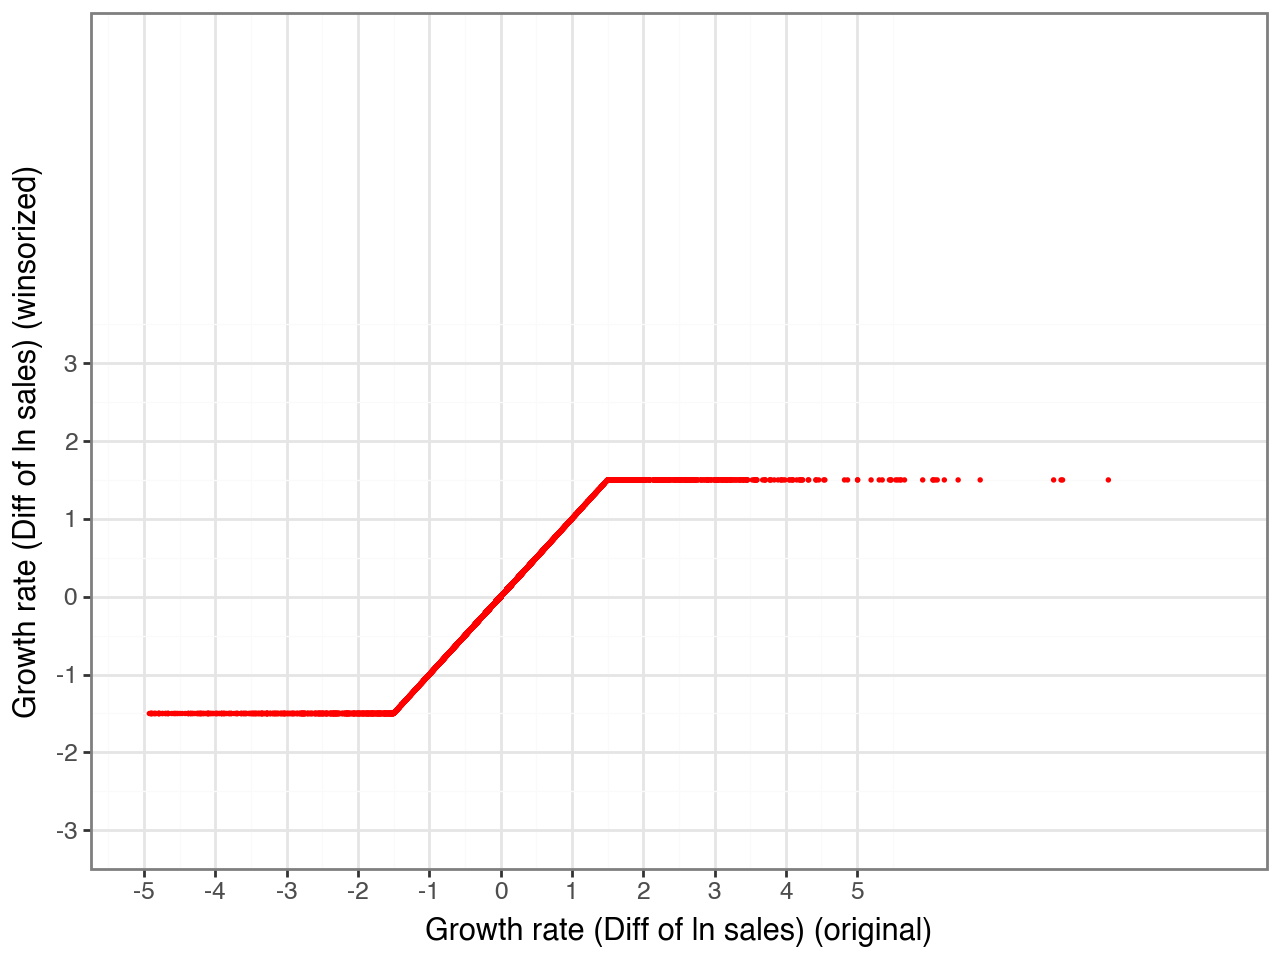

In [43]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)"
    )
    + scale_x_continuous(limits=(-5, 10), breaks=np.arange(-5, 6, 1))
    + scale_y_continuous(limits=(-3, 7), breaks=np.arange(-3, 4, 1))
    + theme_bw()
)

### Define helper functions

In [44]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 
         'C_values': C_values, 
         'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

"""def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)
"""

def create_roc_plot(y_true, y_pred):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot ROC curve line
    ax.plot(fpr, tpr, color='k', linewidth=0.7)
    
    # Fill area under curve
    ax.fill_between(fpr, tpr, alpha=0.3, color='white')
    
    # Add diagonal dotted line
    ax.plot([0, 1], [0, 1], linestyle=':', color='black')
    
    # Set axis labels
    ax.set_xlabel('False Positive Rate (1-Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    
    # Set axis limits and ticks
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    
    # Style similar to theme_bw()
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax


def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

"""def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)"""

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    # Create copy and calculate loss
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot loss line
    ax.plot(all_coords_copy['thresholds'], all_coords_copy['loss'], 
            color= 'k', linewidth=0.7)

    # Add vertical line at optimal threshold
    ax.axvline(x=t, color = 'k')

    # Add annotations
    ax.text(t - 0.04, max(all_coords_copy.loss) - 0.5,
            f"best threshold: {t:.2f}", 
            color = 'k', 
            rotation=90, 
            fontsize = 9)
    
    ax.text(t + 0.06, l,
            f"{l:.2f}",
            fontsize = 9)

    # Set x-axis ticks and limits
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim(0, 1)

    # Style similar to theme_bw()
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.set_facecolor('white')
    ax.set_xlabel('threshold')
    ax.set_ylabel('loss')
    for spine in ax.spines.values():
        spine.set_color('black')

    # Adjust layout
    plt.tight_layout()

    return fig, ax



"""def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)
"""
def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    # Create copy and calculate metrics
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    # Get optimal point
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot ROC curve
    ax.plot(all_coords_copy['sp'], all_coords_copy['se'],
            color='k', linewidth=0.9)
    
    # Add optimal point
    ax.scatter([sp], [se], color='k', s = 100)
    
    # Add text annotation
    ax.text(sp, se + 0.03,
            f"{sp:.2f}, {se:.2f}",
            fontsize = 9,
            ha='center')
    ax.text(sp - 0.02, se - 0.18,
            'specificity (TNR) \n& sensitivity (TPR) \nat the best threshold',
            fontsize = 9,
            ha='center'
           )
    
    # Set axis ticks and limits
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xlabel('specificity')
    ax.set_ylabel('sensitivity')
    
    # Reverse x-axis
    ax.set_xlim(1, 0)
    
    # Style similar to theme_bw()
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    return fig, ax

In [45]:
df = data

#### Prediction variables

In [46]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]

qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]

engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]

engvar3 = [
    "extra_exp_pl_flag_high",
    "extra_inc_pl_flag_high",
    "inventories_pl_flag_high",
    "material_exp_pl_flag_high",
    "personnel_exp_pl_flag_high",
    "curr_liab_bs_flag_high",
    "liq_assets_bs_flag_high",
    "subscribed_cap_bs_flag_high",
    "extra_exp_pl_flag_error",
    "extra_inc_pl_flag_error",
    "inventories_pl_flag_error",
    "material_exp_pl_flag_error",
    "personnel_exp_pl_flag_error",
    "curr_liab_bs_flag_error",
    "liq_assets_bs_flag_error",
    "subscribed_cap_bs_flag_error",
    "extra_profit_loss_pl_flag_low",
    "inc_bef_tax_pl_flag_low",
    "profit_loss_year_pl_flag_low",
    "share_eq_bs_flag_low",
    "extra_profit_loss_pl_flag_high",
    "inc_bef_tax_pl_flag_high",
    "profit_loss_year_pl_flag_high",
    "share_eq_bs_flag_high",
    "extra_profit_loss_pl_flag_zero",
    "inc_bef_tax_pl_flag_zero",
    "profit_loss_year_pl_flag_zero",
    "share_eq_bs_flag_zero"
]

d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]

hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [47]:
df['ind2_cat'] = df['ind2_cat'].cat.remove_unused_categories()

In [48]:
df.ind2_cat.value_counts().sort_index()

ind2_cat
26.0     1075
27.0      646
28.0     1875
29.0      321
30.0      160
33.0     1826
55.0     2212
56.0    11827
Name: count, dtype: int64

In [49]:
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)", df, return_type="dataframe")

In [50]:
ind2_catmat

,C(ind2_cat)[26.0],C(ind2_cat)[27.0],C(ind2_cat)[28.0],C(ind2_cat)[29.0],C(ind2_cat)[30.0],C(ind2_cat)[33.0],C(ind2_cat)[55.0],C(ind2_cat)[56.0]
22845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22846,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22848,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22849,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
45684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45686,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45687,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45688,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [51]:
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

In [52]:
df.m_region_loc.value_counts()

m_region_loc
Central    11836
East        5055
West        3051
Name: count, dtype: int64

In [53]:
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",df, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

In [54]:
df.urban_m.value_counts()

urban_m
3.0    8066
1.0    6305
2.0    5571
Name: count, dtype: int64

In [55]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",df, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [56]:
# Define X1
basevars = df[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = df[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([df[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([df[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([df[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [57]:
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", 
                        df, return_type="dataframe")

#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[20.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", 
                        df, return_type="dataframe")

X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [58]:
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [59]:
rfvars  = pd.concat([df[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars], firm], axis=1)

In [60]:
y = df['fast_growth']

In [61]:
y.mean()

0.2927489720188547

### Simple linear and logistic models

In [62]:
ols_modelx1 = LinearRegression().fit(X1, y)

In [63]:
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.0099
r2:  0.0099
MAE:  0.41
MSE:  0.205
RMSE:  0.4528


In [64]:
ols_modelx1.coef_

array([-0.01126067,  0.00093122,  0.02717141, -0.01673424,  0.0328015 ,
        0.01049476,  0.10598968,  0.08566585,  0.03354697,  0.01132326,
       -0.04116983])

In [65]:
create_coef_matrix(X1, ols_modelx1)

,variable,coefficient
0,sales_mil_log,-0.011261
1,sales_mil_log_sq,0.000931
2,d1_sales_mil_log_mod,0.027171
3,profit_loss_year_pl,-0.016734
4,C(ind2_cat)[27.0],0.032802
5,C(ind2_cat)[28.0],0.010495
6,C(ind2_cat)[29.0],0.105990
7,C(ind2_cat)[30.0],0.085666
8,C(ind2_cat)[33.0],0.033547
9,C(ind2_cat)[55.0],0.011323


In [66]:
ols_modelx1.coef_.flatten()

array([-0.01126067,  0.00093122,  0.02717141, -0.01673424,  0.0328015 ,
        0.01049476,  0.10598968,  0.08566585,  0.03354697,  0.01132326,
       -0.04116983])

In [67]:
glm_modelx1 = LogisticRegression(
    solver = "newton-cg", 
    max_iter = 1000, 
    penalty = None, 
    random_state = 20250224).fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  -0.003
r2:  -0.413
MAE:  0.2925
MSE:  0.2925
RMSE:  0.5409


In [68]:
glm_modelx1.coef_

array([[-0.05731612,  0.00373151,  0.12815264, -0.08112894,  0.15161797,
         0.04801979,  0.47704027,  0.3769592 ,  0.15299825,  0.04780026,
        -0.20309645]])

In [69]:
create_coef_matrix(X1, glm_modelx1)

,variable,coefficient
0,sales_mil_log,-0.057316
1,sales_mil_log_sq,0.003732
2,d1_sales_mil_log_mod,0.128153
3,profit_loss_year_pl,-0.081129
4,C(ind2_cat)[27.0],0.151618
5,C(ind2_cat)[28.0],0.048020
6,C(ind2_cat)[29.0],0.477040
7,C(ind2_cat)[30.0],0.376959
8,C(ind2_cat)[33.0],0.152998
9,C(ind2_cat)[55.0],0.047800


In [70]:
glm_modelx2 = LogisticRegression(
    solver="newton-cg", 
    max_iter=1000, 
    penalty=None).fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.0148
r2:  -0.404
MAE:  0.2907
MSE:  0.2907
RMSE:  0.5392


In [71]:
create_coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,sales_mil_log,-0.056261
1,sales_mil_log_sq,0.003025
2,d1_sales_mil_log_mod,0.084263
3,profit_loss_year_pl,-0.184477
4,C(ind2_cat)[27.0],0.170409
5,C(ind2_cat)[28.0],0.042791
6,C(ind2_cat)[29.0],0.422174
7,C(ind2_cat)[30.0],0.361823
8,C(ind2_cat)[33.0],0.057777
9,C(ind2_cat)[55.0],-0.092904


In [72]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
print(mx2.summary())

Optimization terminated successfully.
         Current function value: 0.590418
         Iterations 5
        Logit Marginal Effects       
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0113      0.004     -3.167      0.002      -0.018      -0.004
sales_mil_log_sq            0.0006      0.000      1.348      0.178      -0.000       0.002
d1_sales_mil_log_mod        0.0170      0.006      2.810      0.005       0.005       0.029
profit_loss_year_pl        -0.0371      0.010     -3.774      0.000      -0.056      -0.018
C(ind2_cat)[27.0]           0.0322      0.022      1.472      0.141      -0.011       0.075
C(ind2_cat)[28.0]           0.0073      0.017      0.431      0.666      -0.026       0.041
C(ind2_cat

In [73]:
ols_model = LinearRegression().fit(X4, y)
regression_results(y, ols_model.predict(X4))

explained_variance:  0.0466
r2:  0.0466
MAE:  0.3949
MSE:  0.1974
RMSE:  0.4443


In [74]:
create_coef_matrix(X4, ols_model)

,variable,coefficient
0,sales_mil_log,-1.084975e-02
1,sales_mil_log_sq,1.585037e-03
2,total_assets_bs,-1.702626e-10
3,fixed_assets_bs,1.006832e-03
4,liq_assets_bs,4.351014e-02
...,...,...
74,C(ind2_cat)[56.0],-5.769136e-02
75,C(m_region_loc)[East],-1.365247e-02
76,C(m_region_loc)[West],-8.521448e-03
77,C(urban_m)[2.0],-1.523703e-02


In [75]:
glm_model = LogisticRegression(
    solver = "newton-cg",
    max_iter = 1000, 
    penalty= None, verbose = 3).fit(X4, y)
regression_results(y, glm_model.predict(X4))

Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 111261.5691750654 <= 0.0001 False
  Inner CG solver iteration 1 stopped with
    sum(|residuals|) <= tol: 123.19015258685621 <= 55693.01669187119
  Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    try line search wolfe1
    wolfe1 line search was successful
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 52641.61180021356 <= 0.0001 False
  Inner CG solver iteration 1 stopped with
    sum(|residuals|) <= tol: 121.57061321501023 <= 26382.431588535048
  Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    try line search wolfe1
    wolfe1 line search was successful
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 14988.076896615872 <= 0.0001 False
  Inner CG solver iteration 1 stopped with
    sum(|residuals|) <= tol: 121.19646558209487 <= 7554.840549800917
  Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    try line search wolfe1
    wolfe1 line search was s

In [76]:
create_coef_matrix(X4, glm_model)

,variable,coefficient
0,sales_mil_log,-5.207502e-02
1,sales_mil_log_sq,7.723972e-03
2,total_assets_bs,-8.082837e-10
3,fixed_assets_bs,-1.203163e+00
4,liq_assets_bs,2.182703e-01
...,...,...
74,C(ind2_cat)[56.0],-2.951618e-01
75,C(m_region_loc)[East],-6.880484e-02
76,C(m_region_loc)[West],-4.433052e-02
77,C(urban_m)[2.0],-7.634051e-02


In [77]:
# Get marginal effects
m = sm.Logit(y,sm.add_constant(X4)).fit().get_margeff()

         Current function value: 0.581163
         Iterations: 35


In [78]:
type(m)

statsmodels.discrete.discrete_margins.DiscreteMargins

In [79]:
print(m.summary())

        Logit Marginal Effects       
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
sales_mil_log                     -0.0103      0.005     -2.117      0.034      -0.020      -0.001
sales_mil_log_sq                   0.0015      0.001      2.660      0.008       0.000       0.003
total_assets_bs                -1.592e-10   7.49e-10     -0.213      0.832   -1.63e-09    1.31e-09
fixed_assets_bs                   -2.2073     84.010     -0.026      0.979    -166.864     162.449
liq_assets_bs                      0.0430      0.014      3.002      0.003       0.015       0.071
curr_assets_bs                    -2.2852     84.010     -0.027      0.978    -166.942     162.372
share_eq_bs                        0.0223      0.012    

In [80]:
t = m.summary().tables[1]
type(t)

statsmodels.iolib.table.SimpleTable

In [81]:
t

,dy/dx,std err,z,P>|z|,[0.025,0.975]
sales_mil_log,-0.0103,0.005,-2.117,0.034,-0.020,-0.001
sales_mil_log_sq,0.0015,0.001,2.660,0.008,0.000,0.003
total_assets_bs,-1.592e-10,7.49e-10,-0.213,0.832,-1.63e-09,1.31e-09
fixed_assets_bs,-2.2073,84.010,-0.026,0.979,-166.864,162.449
liq_assets_bs,0.0430,0.014,3.002,0.003,0.015,0.071
curr_assets_bs,-2.2852,84.010,-0.027,0.978,-166.942,162.372
share_eq_bs,0.0223,0.012,1.860,0.063,-0.001,0.046
subscribed_cap_bs,-0.0376,0.016,-2.400,0.016,-0.068,-0.007
intang_assets_bs,-2.1836,84.010,-0.026,0.979,-166.840,162.473
extra_exp_pl,0.0265,0.309,0.086,0.932,-0.580,0.633


In [82]:
columns = pd.DataFrame(t.data).iloc[0].tolist()

In [83]:
df_marginal_effects = pd.DataFrame(t.data, columns = columns).iloc[1:].astype(
    {'dy/dx': float, 'P>|z|': float})
df_marginal_effects[df_marginal_effects['P>|z|'] <= 0.05].sort_values(by = 'dy/dx', ascending = False).reset_index(drop = True)

,,dy/dx,std err,z,P>|z|,[0.025,0.975]
0,inventories_pl,0.1324,0.023,5.808,0.000,0.088,0.177
1,flag_high_ceo_age,0.1021,0.046,2.223,0.026,0.012,0.192
2,C(ind2_cat)[29.0],0.0878,0.027,3.221,0.001,0.034,0.141
3,balsheet_notfullyear,0.0751,0.025,3.059,0.002,0.027,0.123
4,C(ind2_cat)[30.0],0.0737,0.035,2.083,0.037,0.004,0.143
5,personnel_exp_pl,0.0729,0.020,3.630,0.000,0.034,0.112
6,material_exp_pl,0.0544,0.021,2.572,0.010,0.013,0.096
7,liq_assets_bs,0.0430,0.014,3.002,0.003,0.015,0.071
8,foreign_management,0.0333,0.012,2.703,0.007,0.009,0.057
9,sales_mil_log_sq,0.0015,0.001,2.660,0.008,0.000,0.003


In [84]:
indices = range(len(df))  # [0, 1, 2, ..., len(df)-1]
index_train, index_holdout = train_test_split(
    indices, 
    train_size=round(0.8 * len(df.index)), 
    random_state=42
)
y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [85]:
print('Total')
print(df['fast_growth'].value_counts(normalize=True), '\n')
print('Train')
print(df.iloc[index_train]['fast_growth'].value_counts(normalize=True), '\n')
print('Holdout')
print(df.iloc[index_holdout]['fast_growth'].value_counts(normalize=True), '\n')

Total
fast_growth
0    0.707251
1    0.292749
Name: proportion, dtype: float64 

Train
fast_growth
0    0.70885
1    0.29115
Name: proportion, dtype: float64 

Holdout
fast_growth
0    0.700853
1    0.299147
Name: proportion, dtype: float64 



In [86]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20250224)

In [87]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [88]:
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [89]:
for i in range(len(logit_model_vars)):
    print(datetime.datetime.now(), f'Running regression {i}...')
    LRCV_brier = LogisticRegressionCV(
        Cs = Cs_value_logit, 
        cv = k, # simply the number of folds
        refit = True, 
        scoring = 'neg_brier_score', 
        solver = "newton-cg", 
        tol=1e-7, 
        random_state = 20250224)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

2025-03-09 21:26:51.331110 Running regression 0...
2025-03-09 21:26:51.554661 Running regression 1...
2025-03-09 21:26:51.886579 Running regression 2...
2025-03-09 21:26:58.596917 Running regression 3...
2025-03-09 21:27:15.242752 Running regression 4...


In [90]:
np.sqrt(-1*logit_models['X5'].scores_[1].flatten())

array([0.4483959 , 0.44545667, 0.44756775, 0.44534075, 0.44215015])

In [91]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5
0,0.454678,0.450770,0.449942,0.448178,0.448396
1,0.451134,0.446613,0.446843,0.444920,0.445457
2,0.454278,0.450263,0.447670,0.446077,0.447568
3,0.453250,0.449142,0.447554,0.445316,0.445341
4,0.448826,0.444309,0.443491,0.441757,0.442150


In [92]:
normalized_logitvars = pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns = logitvars.columns

In [93]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]

In [94]:
Cs_values # the strength of the regularization -> supressing unimportant variables

[0.0007835025698884291,
 0.0016880051162967622,
 0.003636696779501047,
 0.007835025698884288,
 0.016880051162967608,
 0.03636696779501043,
 0.07835025698884283,
 0.1688005116296761,
 0.3636696779501044,
 0.7835025698884275]

In [95]:
logLasso = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = k, 
    refit = True, 
    scoring = 'accuracy', 
    solver = 'liblinear',
    random_state = 20250224)

In [96]:
%%time
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

CPU times: user 1min 4s, sys: 2 s, total: 1min 6s
Wall time: 58.2 s


In [97]:
cv_summary_lasso = cv_summary(lambdas, Cs_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000784,0.708851
1,0.046416,0.001688,0.708851
2,0.021544,0.003637,0.708851
3,0.010000,0.007835,0.710606
4,0.004642,0.016880,0.712800
5,0.002154,0.036367,0.713176
6,0.001000,0.078350,0.714178
7,0.000464,0.168801,0.713614
8,0.000215,0.363670,0.712862
9,0.000100,0.783503,0.712925


In [98]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]
best_lambda

0.001000000000000001

In [99]:
create_coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,sales_mil_log,-0.037395
1,sales_mil_log_sq,0.097586
2,total_assets_bs,0.000000
3,fixed_assets_bs,0.060959
4,liq_assets_bs,0.067191
...,...,...
158,C(ind2_cat)[56.0]:labor_avg_mod,0.004497
159,sales_mil_log:age,-0.042641
160,sales_mil_log:female,-0.007696
161,sales_mil_log:profit_loss_year_pl,0.005164


In [100]:
#refit with negative brier score so we have RMSE values for the same cv split

logLasso_brier = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', 
    cv = k, 
    refit = True, 
    scoring = 'neg_brier_score', 
    solver = "liblinear", 
    random_state = 20250224)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [101]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [102]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.454678,0.450770,0.449942,0.448178,0.448396,0.447782
1,0.451134,0.446613,0.446843,0.444920,0.445457,0.445370
2,0.454278,0.450263,0.447670,0.446077,0.447568,0.447155
3,0.453250,0.449142,0.447554,0.445316,0.445341,0.444271
4,0.448826,0.444309,0.443491,0.441757,0.442150,0.442379


In [103]:
CV_AUC_folds = dict()

In [104]:
%%time
for i in range(len(logit_model_vars)):
    print(datetime.datetime.now(), f'Running regression {i}...')
    LRCV_auc = LogisticRegressionCV(
        Cs = Cs_value_logit, 
        cv = k, 
        refit = True, 
        scoring = 'roc_auc', 
        solver= "newton-cg", 
        tol = 1e-7, 
        random_state = 20250224)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

2025-03-09 21:29:58.205973 Running regression 0...
2025-03-09 21:29:58.537860 Running regression 1...
2025-03-09 21:29:58.849146 Running regression 2...
2025-03-09 21:30:05.755355 Running regression 3...
2025-03-09 21:30:23.175749 Running regression 4...
CPU times: user 8min 38s, sys: 7.73 s, total: 8min 46s
Wall time: 1min 12s


In [105]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5
0,0.557410,0.598623,0.600783,0.610622,0.615078
1,0.564443,0.604629,0.602298,0.612118,0.612931
2,0.543225,0.592918,0.610255,0.621100,0.616235
3,0.550853,0.594264,0.607445,0.621945,0.625183
4,0.547219,0.600938,0.607455,0.619718,0.622683


### LASSO

In [106]:
%%time
#refit with AUC so we have AUC values for the same cv split

logLasso_auc = LogisticRegressionCV(
    Cs=Cs_values, 
    penalty='l1', # this makes it lasso
    cv=k, 
    refit=True, scoring='roc_auc', 
    solver="liblinear", 
    random_state = 20250224)

logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

CPU times: user 1min 6s, sys: 1.92 s, total: 1min 8s
Wall time: 59.1 s


In [107]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.557410,0.598623,0.600783,0.610622,0.615078,0.619514
1,0.564443,0.604629,0.602298,0.612118,0.612931,0.616620
2,0.543225,0.592918,0.610255,0.621100,0.616235,0.615259
3,0.550853,0.594264,0.607445,0.621945,0.625183,0.631650
4,0.547219,0.600938,0.607455,0.619718,0.622683,0.620657


In [108]:
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

In [109]:
for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

In [110]:
CV_AUC

{'X1': 0.5526299667712008,
 'X2': 0.5982744430726504,
 'X3': 0.6056474006831238,
 'X4': 0.6171006279321329,
 'X5': 0.6184219679305367,
 'LASSO': 0.6207400044964355}

In [111]:
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [112]:
for k, v in nvars.items():
    print(f'{k.ljust(5)}: {str(v).rjust(3)}')

X1   :  11
X2   :  18
X3   :  35
X4   :  79
X5   : 163
LASSO: 107


In [113]:
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [114]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.452433,0.552630
X2,18.0,0.448219,0.598274
X3,35.0,0.447100,0.605647
X4,79.0,0.445250,0.617101
X5,163.0,0.445782,0.618422
LASSO,107.0,0.445391,0.620740


In [115]:
best_model = logit_models['LASSO']
normalized_logitvars_holdout = pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_holdout]))
normalized_logitvars_holdout.columns = logitvars.columns
best_model_X_holdout = normalized_logitvars_holdout
logit_predicted_probabilities_holdout = best_model.predict_proba(normalized_logitvars_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.447

In [116]:
logit_predicted_probabilities_holdout

array([0.25071192, 0.1987003 , 0.56876769, ..., 0.09674354, 0.58605886,
       0.383048  ])

In [117]:
fpr, tpr, thresholds = roc_curve(y_holdout, logit_predicted_probabilities_holdout)

In [118]:
df_ = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds
})

In [119]:
df_.iloc[:10]

,fpr,tpr,thresholds
0,0.000000,0.000000,inf
1,0.000000,0.000838,0.938257
2,0.000000,0.001676,0.808528
3,0.000358,0.001676,0.803376
4,0.000358,0.003353,0.716295
5,0.000716,0.003353,0.712498
6,0.000716,0.004191,0.704459
7,0.001073,0.004191,0.696637
8,0.001073,0.008382,0.666047
9,0.001431,0.008382,0.661642


In [120]:
df_.iloc[-10:]

,fpr,tpr,thresholds
1616,0.992487,0.995809,0.104148
1617,0.994633,0.995809,0.099457
1618,0.994633,0.996647,0.096744
1619,0.998211,0.996647,0.067468
1620,0.998211,0.997485,0.064254
1621,0.998927,0.997485,0.061157
1622,0.998927,0.999162,0.051785
1623,0.999284,0.999162,0.044817
1624,0.999284,1.000000,0.037486
1625,1.000000,1.000000,0.002341


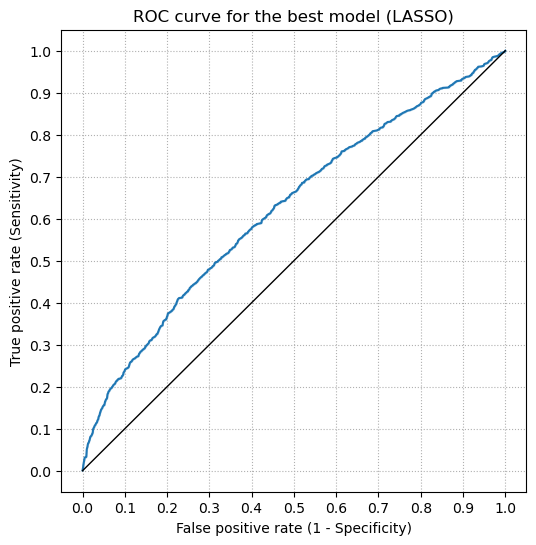

In [121]:
plt.figure(figsize = (6,6))
ax = sns.lineplot(
    data = df_,
    x = fpr, 
    y = tpr)
ax.set_title('ROC curve for the best model (LASSO)')
ax.set_xlabel("False positive rate (1 - Specificity)"), 
ax.set_ylabel("True positive rate (Sensitivity)")
ax.set_xticks([x/10 for x in range(0,11,1)])
ax.set_yticks([x/10 for x in range(0,11,1)])
ax.plot(df_.fpr, df_.fpr, color = 'k', linewidth = 1)
ax.grid(True, linestyle=':');
plt.show()

In [122]:
logit_class_prediction = best_model.predict(best_model_X_holdout)

In [123]:
logit_class_prediction

array([0, 0, 1, ..., 0, 1, 0])

In [124]:
values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)

In [125]:
values

array([0, 1])

In [126]:
counts

array([3852,  136])

In [127]:
print(values[0],' (no fast growth): ',counts[0])
print(values[1],' (fast growth): ',counts[1])

0  (no fast growth):  3852
1  (fast growth):  136


In [128]:
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actual no fast growth', 'Actual fast growth'], 
    columns=['Predicted no fast growth', 'Predicted fast growth'])
cm1

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,2748,47
Actual fast growth,1104,89


In [129]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actual no fast growth', 'Actual fast growth'], 
    columns=['Predicted no fast growth', 'Predicted fast growth'])
cm1b

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,2748,47
Actual fast growth,1104,89


In [130]:
print(f'TPR: {round(cm1b.iloc[1,1] / cm1b.iloc[1].sum(), 3)}')
print(f'FPR: {round(cm1b.iloc[0,1] / cm1b.iloc[0].sum(), 3)}')

TPR: 0.075
FPR: 0.017


In [131]:
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.292

In [132]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no fast growth', 'Actual fast growth'], 
    columns=['Predicted no fast growth', 'Predicted fast growth'])
cm2

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,1707,1088
Actual fast growth,518,675


In [133]:
print(f'TPR: {round(cm2.iloc[1,1] / cm2.iloc[1].sum(), 3)}')
print(f'FPR: {round(cm2.iloc[0,1] / cm2.iloc[0].sum(), 3)}')

TPR: 0.566
FPR: 0.389


In [134]:
FP = 1.3
FN = 1
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)
print(f'Prevelance: {prevelance:,.3f}')
print(f'Simple best threshold estimation: {FP/(FP+FN):,.3f}.')

Prevelance: 0.291
Simple best threshold estimation: 0.565.


In [135]:
for i, v in enumerate(logit_models):
    print(i, v)

0 X1
1 X2
2 X3
3 X4
4 X5
5 LASSO


In [136]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20250224)

In [137]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    
    fold = 0
    
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
    
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)

        # this is where we pick the best threshold for minimal loss at each model for every single fold
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                    ),
                    thresholds
                )
            )
            , key=lambda i: i[0], reverse=True)[0][1]
        
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()

        # expected loss for each model for every single fold
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    # best threshold and expected loss for each model (averaging out the folds)
    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # best threshold and expected loss for each model for fold5 ONLY
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [138]:
fold5_all_coords['X1']

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,901.0,2289.0,901,2289,3190,inf
1,0.0,1.0,900.0,2289.0,901,2289,3190,0.551544
2,0.0,2.0,899.0,2289.0,901,2289,3190,0.524565
3,1.0,2.0,899.0,2288.0,901,2289,3190,0.480865
4,1.0,4.0,897.0,2288.0,901,2289,3190,0.458354
...,...,...,...,...,...,...,...,...
1296,2280.0,899.0,2.0,9.0,901,2289,3190,0.212598
1297,2280.0,900.0,1.0,9.0,901,2289,3190,0.210971
1298,2281.0,900.0,1.0,8.0,901,2289,3190,0.209646
1299,2281.0,901.0,0.0,8.0,901,2289,3190,0.209358


In [139]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

In [140]:
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,inf,0.458354,0.290604,0.281599
1,X2,0.512969,0.536394,0.289344,0.281066
2,X3,0.529610,0.620440,0.288723,0.281191
3,X4,0.524175,0.580078,0.286147,0.281160
4,X5,0.587111,0.799106,0.287614,0.281912
5,LASSO,0.568126,0.745613,0.287821,0.281693


In [141]:
model_to_plot = 'LASSO'

In [142]:
fold5_all_coords[model_to_plot]

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,901.0,2289.0,901,2289,3190,inf
1,0.0,1.0,900.0,2289.0,901,2289,3190,0.920286
2,1.0,1.0,900.0,2288.0,901,2289,3190,0.841237
3,1.0,3.0,898.0,2288.0,901,2289,3190,0.770477
4,2.0,3.0,898.0,2287.0,901,2289,3190,0.762691
...,...,...,...,...,...,...,...,...
1238,2273.0,899.0,2.0,16.0,901,2289,3190,0.100249
1239,2273.0,900.0,1.0,16.0,901,2289,3190,0.090688
1240,2278.0,900.0,1.0,11.0,901,2289,3190,0.077000
1241,2278.0,901.0,0.0,11.0,901,2289,3190,0.061194


In [143]:
fold5_threshold[model_to_plot]

0.7456132666361341

In [144]:
fold5_expected_loss[model_to_plot]

0.28169278996865205

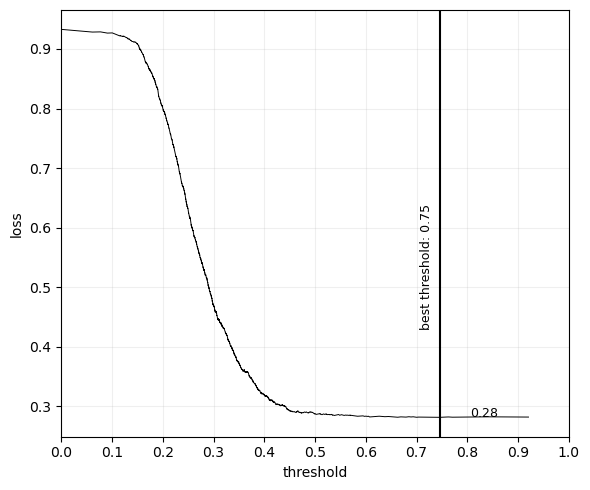

In [145]:
create_loss_plot(
    fold5_all_coords[model_to_plot], 
    fold5_threshold[model_to_plot], 
    fold5_expected_loss[model_to_plot]);
plt.show()

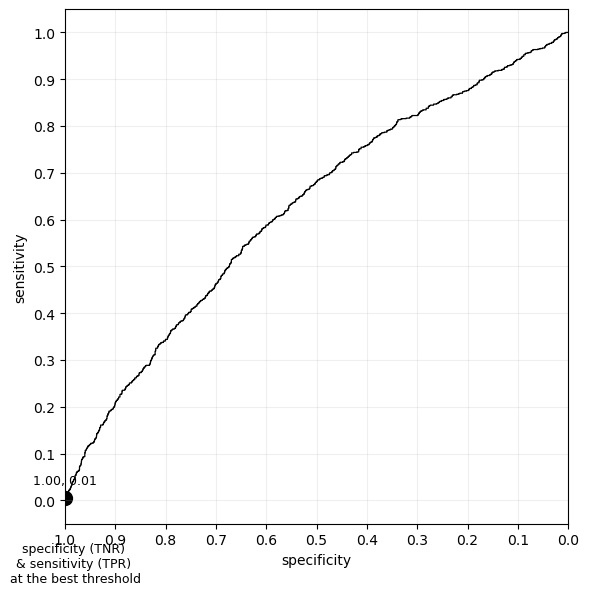

In [146]:
model_to_plot = 'LASSO'
create_roc_plot_with_optimal(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]);

In [147]:
best_logit_optimal_treshold = best_thresholds_cv["LASSO"]
best_logit_optimal_treshold

0.5681264008504929

In [148]:
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.294

In [149]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no fast growth', 'Actual fast growth'], 
    columns=['Predicted no fast growth', 'Predicted fast growth'])
cm3.head()

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,2781,14
Actual fast growth,1156,37


In [229]:
cm3

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,2781,14
Actual fast growth,1156,37


In [150]:
print(f'TPR: {round(cm3.iloc[1,1] / cm3.iloc[1].sum(), 3)}')
print(f'FPR: {round(cm3.iloc[0,1] / cm3.iloc[0].sum(), 3)}')

TPR: 0.031
FPR: 0.005


### Random Forest

In [151]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

In [152]:
rfvars_train.columns

Index(['sales_mil', 'd1_sales_mil_log', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'female', 'ceo_age', 'flag_high_ceo_age',
       'flag_low_ceo_age', 'flag_miss_ceo_age', 'ceo_count', 'labor_avg_mod',
       'flag_miss_labor_avg', 'foreign_management', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'age', 'age2', 'new',
       'C(ind2_cat)[27.0]', 'C(ind2_cat)[28.0]', 'C(ind2_cat)[29.0]',
       'C(ind2_cat)[30.0]', 'C(ind2_cat)[33.0]', 'C(ind2_cat)[55.0]',
       'C(ind2_cat)[56.0]', 'C(m_region_loc)[East]', 'C(m_region_loc)[West]',
       'C(urban_m)[2.0]', 'C(urban_m)[3.0]'],
      dtype='object')

In [153]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [154]:
prob_forest = RandomForestClassifier(
    random_state=20250224, 
    n_estimators=50, # this should be higher, but it is kept low in order to control runtime on class
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv = 5, 
    refit='accuracy', # Refit an estimator using the best found parameters on the whole dataset.
                      # For multiple metric evaluation, this needs to be a str denoting the scorer 
                      # that would be used to find the best parameters for refitting the estimator at the end.
    scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1)

In [155]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

CPU times: user 1.7 s, sys: 157 ms, total: 1.85 s
Wall time: 11.5 s


In [156]:
prob_forest_fit.cv_results_

{'mean_fit_time': array([1.59721799, 1.49276099, 1.84364305, 1.78440356, 2.02320795,
        1.74344363]),
 'std_fit_time': array([0.02375764, 0.02266949, 0.0235094 , 0.05246308, 0.09181157,
        0.07776297]),
 'mean_score_time': array([0.06355424, 0.05115981, 0.05913248, 0.0525435 , 0.05340567,
        0.03743553]),
 'std_score_time': array([0.00789866, 0.00119978, 0.00661852, 0.00248993, 0.00523513,
        0.00357687]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[5, 5, 6, 6, 7, 7],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'param_min_samples_split': masked_array(data=[11, 16, 11, 16, 11, 16],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'criterion': 'gini', 'max_features': 5,

In [157]:
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5
cv_accuracy

array([0.71449144, 0.7159329 , 0.71649732, 0.71637191, 0.71543161,
       0.71693611])

In [158]:
np.max(cv_accuracy)

0.7169361124400622

In [159]:
prob_forest_fit.best_score_

0.7169361124400622

In [160]:
cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

array([0.62207261, 0.62367982, 0.62673327, 0.62585434, 0.62277183,
       0.6239001 ])

In [161]:
cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

array([0.44455214, 0.44409011, 0.44388527, 0.44387323, 0.44468766,
       0.44427009])

In [162]:
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [163]:
prob_forest_cv_results.style.format(
    {
        'cv_accuracy': '{:.5f}',
        'cv_auc': '{:.5f}',
        'cv_rmse': '{:.5f}'
    }
)

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.71449,0.62207,0.44455
1,5,16,0.71593,0.62368,0.44409
2,6,11,0.71650,0.62673,0.44389
3,6,16,0.71637,0.62585,0.44387
4,7,11,0.71543,0.62277,0.44469
5,7,16,0.71694,0.62390,0.44427


In [164]:
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

In [165]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [166]:
CV_RMSE

{'X1': 0.45243309787103314,
 'X2': 0.448219419518573,
 'X3': 0.4470999119829048,
 'X4': 0.44524966317581194,
 'X5': 0.4457822451480766,
 'LASSO': 0.4453914856998198,
 'rf_p': 0.4442700894675795}

In [167]:
CV_AUC

{'X1': 0.5526299667712008,
 'X2': 0.5982744430726504,
 'X3': 0.6056474006831238,
 'X4': 0.6171006279321329,
 'X5': 0.6184219679305367,
 'LASSO': 0.6207400044964355,
 'rf_p': 0.6239000969460131}

In [168]:
CV_RMSE_folds_rf_p = list()

for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)

CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()

for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)

CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p

In [169]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO,rf_p
0,0.557410,0.598623,0.600783,0.610622,0.615078,0.619514,0.614473
1,0.564443,0.604629,0.602298,0.612118,0.612931,0.616620,0.636314
2,0.543225,0.592918,0.610255,0.621100,0.616235,0.615259,0.612514
3,0.550853,0.594264,0.607445,0.621945,0.625183,0.631650,0.629634
4,0.547219,0.600938,0.607455,0.619718,0.622683,0.620657,0.626566


In [170]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    print(f'{datetime.datetime.now()}: fold {fold}...') 
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(
        random_state=20250224, 
        n_estimators=50, # make it higher in practice (default being 100)
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split
    )
    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

2025-03-09 21:32:27.456850: fold 0...
2025-03-09 21:32:28.810384: fold 1...
2025-03-09 21:32:30.093176: fold 2...
2025-03-09 21:32:31.426842: fold 3...
2025-03-09 21:32:32.747692: fold 4...


In [171]:
for f, t in enumerate(best_thresholds):
    print(f'Fold: {f}, best threshold: {t:,.4f}.')

Fold: 0, best threshold: 0.6041.
Fold: 1, best threshold: 0.6569.
Fold: 2, best threshold: 0.5992.
Fold: 3, best threshold: 0.6503.
Fold: 4, best threshold: 0.6323.


In [172]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_rf

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,901.0,2289.0,901,2289,3190,inf
1,0.0,1.0,900.0,2289.0,901,2289,3190,0.921374
2,1.0,1.0,900.0,2288.0,901,2289,3190,0.828305
3,1.0,3.0,898.0,2288.0,901,2289,3190,0.810972
4,2.0,3.0,898.0,2287.0,901,2289,3190,0.797799
...,...,...,...,...,...,...,...,...
1220,2276.0,899.0,2.0,13.0,901,2289,3190,0.079912
1221,2276.0,900.0,1.0,13.0,901,2289,3190,0.078052
1222,2286.0,900.0,1.0,3.0,901,2289,3190,0.062094
1223,2286.0,901.0,0.0,3.0,901,2289,3190,0.060879


In [173]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [174]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.444,0.624,0.629,0.632,0.285,0.28


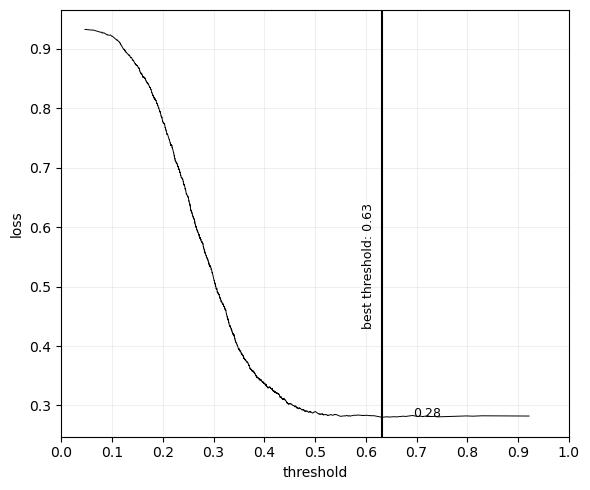

In [175]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf);
plt.show()

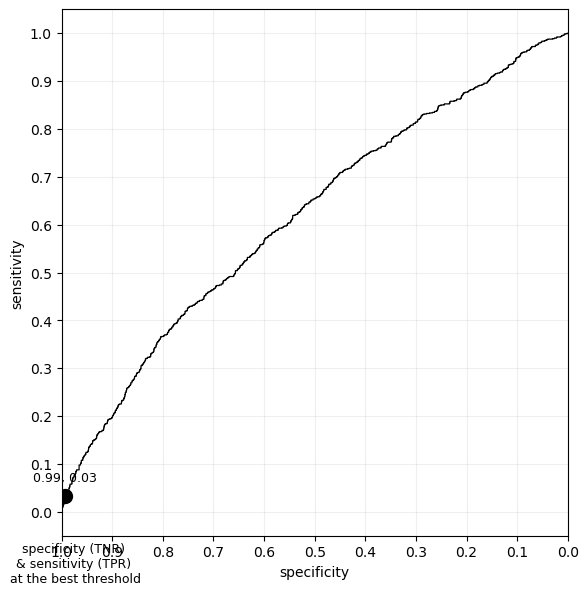

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='specificity', ylabel='sensitivity'>)

In [176]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

In [177]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.447

In [178]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.623

In [179]:
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.292

In [180]:
import datetime
print(datetime.datetime.now())

2025-03-09 21:32:34.616465


In [181]:
prob_forest_best_fold.predict(rfvars_holdout)

array([0, 0, 1, ..., 0, 1, 0])

In [182]:
prob_forest_best_fold.predict_proba(rfvars_holdout)

array([[0.61764314, 0.38235686],
       [0.62164069, 0.37835931],
       [0.44018877, 0.55981123],
       ...,
       [0.61939023, 0.38060977],
       [0.24569288, 0.75430712],
       [0.66330253, 0.33669747]])

In [183]:
nvars['rf_p'] = len(rfvars.columns)

In [184]:
summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

In [185]:
summary_results.style.format(
    {
        'CV threshold': '{:.4f}',
        'CV AUC': '{:.4f}',
        'CV RMSE': '{:.4f}',
        'CV expected Loss': '{:.4f}'
    }
)

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.4524,0.5526,inf,0.2906
1,X2,18,0.4482,0.5983,0.5130,0.2893
2,X3,35,0.4471,0.6056,0.5296,0.2887
3,X4,79,0.4452,0.6171,0.5242,0.2861
4,X5,163,0.4458,0.6184,0.5871,0.2876
5,LASSO,107,0.4454,0.6207,0.5681,0.2878
6,rf_p,44,0.4443,0.6239,0.6285,0.2850


### GBM Boosting

In [186]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [187]:
gbvars_train = rfvars.iloc[index_train]
gbvars_holdout = rfvars.iloc[index_holdout]

# Define a hyperparameter grid for Gradient Boosting
grid_gb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5]
}

# Initialize the Gradient Boosting classifier with a fixed random state
prob_gb = GradientBoostingClassifier(random_state=20250224)

# Set up GridSearchCV with multiple scoring metrics; refit based on accuracy
prob_gb_grid = GridSearchCV(
    estimator=prob_gb,
    param_grid=grid_gb,
    cv=5,
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'],
    refit='accuracy',
    n_jobs=-1
)

# Fit the grid search on the training data (use %%time in a Jupyter cell to time it)
%time prob_gb_fit = prob_gb_grid.fit(gbvars_train, y_train)

# Retrieve cross-validation results
cv_results = prob_gb_fit.cv_results_

# Calculate average accuracy across the folds for each parameter set
cv_accuracy = np.zeros(len(cv_results['mean_test_accuracy']))
for i in range(5):
    cv_accuracy += np.array(cv_results[f'split{i}_test_accuracy'])
cv_accuracy /= 5

# Calculate average AUC across the folds
cv_auc = np.zeros(len(cv_results['mean_test_roc_auc']))
for i in range(5):
    cv_auc += np.array(cv_results[f'split{i}_test_roc_auc'])
cv_auc /= 5

# Calculate average RMSE across the folds using the negative brier score
cv_rmse = np.zeros(len(cv_results['mean_test_neg_brier_score']))
for i in range(5):
    # Convert negative brier score to RMSE
    cv_rmse += np.sqrt(-np.array(cv_results[f'split{i}_test_neg_brier_score']))
cv_rmse /= 5

# Summarize the CV results in a DataFrame
prob_gb_cv_results = pd.DataFrame({
    'learning_rate': cv_results['param_learning_rate'],
    'n_estimators': cv_results['param_n_estimators'],
    'max_depth': cv_results['param_max_depth'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

print(prob_gb_cv_results.style.format({
    'cv_accuracy': '{:.5f}',
    'cv_auc': '{:.5f}',
    'cv_rmse': '{:.5f}'
}))

# Retrieve best hyperparameters
best_params_gb = prob_gb_fit.best_params_
print("Best Hyperparameters:", best_params_gb)

CPU times: user 6.2 s, sys: 251 ms, total: 6.45 s
Wall time: 2min 51s
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [188]:
best_index = prob_gb_fit.best_index_

auc_folds_gbm = [cv_results[f'split{i}_test_roc_auc'][best_index] for i in range(5)]
rmse_folds_gbm = [np.sqrt(-cv_results[f'split{i}_test_neg_brier_score'][best_index]) for i in range(5)]

CV_AUC['gbm_p'] = auc_folds_gbm
CV_RMSE['gbm_p'] = rmse_folds_gbm

print("Per-fold ROC AUC for best GBM model:", CV_AUC['gbm_p'])
print("Per-fold RMSE for best GBM model:", CV_RMSE['gbm_p'])

Per-fold ROC AUC for best GBM model: [0.6427164202116876, 0.6439522641593834, 0.6231040002893312, 0.6464263314231765, 0.6466346325511112]
Per-fold RMSE for best GBM model: [0.44142010214848887, 0.4404243598327868, 0.44402423571375343, 0.4404864570867284, 0.44107579118892]


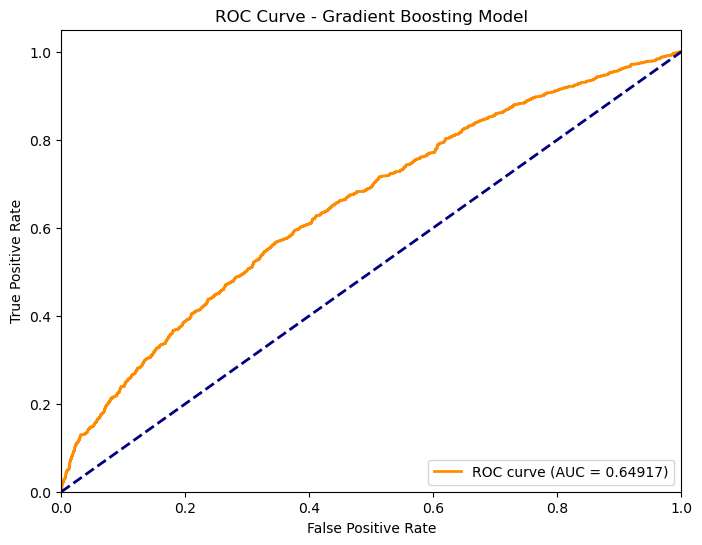

In [189]:
y_proba = prob_gb_fit.predict_proba(gbvars_holdout)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_holdout, y_proba)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Model')
plt.legend(loc="lower right")
plt.show()

In [190]:
best_thresholds = list()
expected_loss = list()
rfvars_train.columns = rfvars_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
fold = 0
for train_index, test_index in k.split(rfvars_train):
    print(f'{datetime.datetime.now()}: fold {fold}...') 
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    gbm_best = GradientBoostingClassifier(
    random_state=20250224, 
    n_estimators=100, 
    max_depth=3,         # you can choose a value, e.g. 3 or another tuned value
    learning_rate=0.1    # likewise, set an appropriate learning rate
)
    
    gbm_best_fold = gbm_best.fit(X_fold_train, y_fold_train)
    pred_fold = gbm_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

2025-03-09 21:35:26.371780: fold 0...
2025-03-09 21:35:31.463798: fold 1...
2025-03-09 21:35:36.467012: fold 2...
2025-03-09 21:35:41.469368: fold 3...
2025-03-09 21:35:46.138054: fold 4...


In [191]:
for f, t in enumerate(best_thresholds):
    print(f'Fold: {f}, best threshold: {t:,.4f}.')

Fold: 0, best threshold: 0.5209.
Fold: 1, best threshold: 0.6690.
Fold: 2, best threshold: 0.4855.
Fold: 3, best threshold: 0.5647.
Fold: 4, best threshold: 0.6756.


In [192]:
for f, l in enumerate(expected_loss):
    print(f'Fold: {f}, smalles loss: {l:,.4f}.')

Fold: 0, smalles loss: 0.2889.
Fold: 1, smalles loss: 0.2860.
Fold: 2, smalles loss: 0.2876.
Fold: 3, smalles loss: 0.2835.
Fold: 4, smalles loss: 0.2784.


In [193]:
fold5_threshold_gbm = best_threshold
fold5_expected_loss_gbm = curr_exp_loss

all_coords_gbm = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_gbm

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,901.0,2289.0,901,2289,3190,inf
1,0.0,1.0,900.0,2289.0,901,2289,3190,0.831899
2,0.0,2.0,899.0,2289.0,901,2289,3190,0.802036
3,2.0,2.0,899.0,2287.0,901,2289,3190,0.776496
4,2.0,11.0,890.0,2287.0,901,2289,3190,0.699453
...,...,...,...,...,...,...,...,...
1229,2280.0,899.0,2.0,9.0,901,2289,3190,0.106588
1230,2280.0,900.0,1.0,9.0,901,2289,3190,0.106331
1231,2282.0,900.0,1.0,7.0,901,2289,3190,0.104159
1232,2282.0,901.0,0.0,7.0,901,2289,3190,0.101672


In [194]:
expected_loss_cv['gbm_p'] = np.mean(expected_loss)
best_thresholds_cv['gbm_p'] = np.mean(best_thresholds)

In [195]:
cv_rmse_avg = np.mean(CV_RMSE['gbm_p'])
cv_auc_avg = np.mean(CV_AUC['gbm_p'])
opt_threshold_avg = np.mean(best_thresholds_cv['gbm_p'])  # if best_thresholds_cv['gbm_p'] is a list
exp_loss_avg = np.mean(expected_loss_cv['gbm_p'])

gbm_summary = pd.DataFrame({
    'CV RMSE': [round(cv_rmse_avg, 3)],
    'CV AUC': [round(cv_auc_avg, 3)],
    'Avg of optimal thresholds': [round(opt_threshold_avg, 3)],
    'Threshold for Fold5': [round(best_threshold, 3)],
    'Avg expected loss': [round(exp_loss_avg, 3)],
    'Expected loss for Fold5': [round(curr_exp_loss, 3)]
})

gbm_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.441,0.641,0.583,0.676,0.285,0.278


### XGB Boosting

In [196]:
import xgboost as xgb

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

CPU times: user 498 ms, sys: 163 ms, total: 661 ms
Wall time: 6.07 s
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Holdout ROC AUC: 0.65162


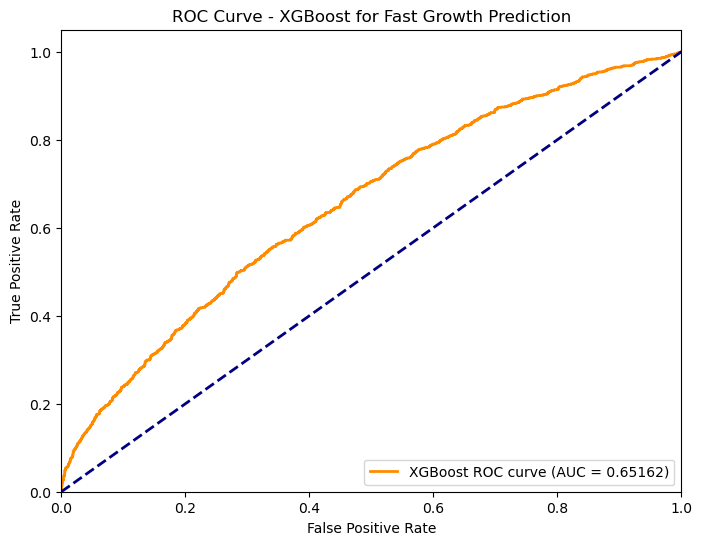

In [197]:
xgbvars_train = rfvars.iloc[index_train].copy()
xgbvars_holdout = rfvars.iloc[index_holdout].copy()

# Clean column names to remove forbidden characters for XGBoost
xgbvars_train.columns = xgbvars_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
xgbvars_holdout.columns = xgbvars_holdout.columns.str.replace(r'[\[\]<>]', '', regex=True)

# Define hyperparameter grid for XGBoost
grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5]
}

# Initialize the XGBoost classifier with a fixed random state
prob_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=20250224
)

# Set up GridSearchCV with multiple scoring metrics; refit based on accuracy
prob_xgb_grid = GridSearchCV(
    estimator=prob_xgb,
    param_grid=grid_xgb,
    cv=5,
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'],
    refit='accuracy',
    n_jobs=-1
)

# Fit the grid search on the training data
%time prob_xgb_fit = prob_xgb_grid.fit(xgbvars_train, y_train)

# Retrieve cross-validation results
cv_results_xgb = prob_xgb_fit.cv_results_

# Calculate average accuracy across the folds for each parameter set
cv_accuracy_xgb = np.zeros(len(cv_results_xgb['mean_test_accuracy']))
for i in range(5):
    cv_accuracy_xgb += np.array(cv_results_xgb[f'split{i}_test_accuracy'])
cv_accuracy_xgb /= 5

# Calculate average AUC across the folds
cv_auc_xgb = np.zeros(len(cv_results_xgb['mean_test_roc_auc']))
for i in range(5):
    cv_auc_xgb += np.array(cv_results_xgb[f'split{i}_test_roc_auc'])
cv_auc_xgb /= 5

# Calculate average RMSE across the folds using the negative brier score
cv_rmse_xgb = np.zeros(len(cv_results_xgb['mean_test_neg_brier_score']))
for i in range(5):
    cv_rmse_xgb += np.sqrt(-np.array(cv_results_xgb[f'split{i}_test_neg_brier_score']))
cv_rmse_xgb /= 5

# Summarize the CV results in a DataFrame
prob_xgb_cv_results = pd.DataFrame({
    'learning_rate': cv_results_xgb['param_learning_rate'],
    'n_estimators': cv_results_xgb['param_n_estimators'],
    'max_depth': cv_results_xgb['param_max_depth'],
    'cv_accuracy': cv_accuracy_xgb,
    'cv_auc': cv_auc_xgb,
    'cv_rmse': cv_rmse_xgb
})

print(prob_xgb_cv_results.style.format({
    'cv_accuracy': '{:.5f}',
    'cv_auc': '{:.5f}',
    'cv_rmse': '{:.5f}'
}))

# Retrieve best hyperparameters
best_params_xgb = prob_xgb_fit.best_params_
print("Best Hyperparameters:", best_params_xgb)

# Optionally, you can now evaluate the best model on your holdout set:
y_pred_proba = prob_xgb_fit.best_estimator_.predict_proba(xgbvars_holdout)[:, 1]
roc_auc_val = roc_auc_score(y_holdout, y_pred_proba)
print("Holdout ROC AUC:", round(roc_auc_val, 5))

fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='XGBoost ROC curve (AUC = %0.5f)' % roc_auc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost for Fast Growth Prediction')
plt.legend(loc="lower right")
plt.show()

In [198]:
best_index = prob_xgb_fit.best_index_

# Create lists for each fold’s metrics
auc_folds = [cv_results_xgb[f'split{i}_test_roc_auc'][best_index] for i in range(5)]
rmse_folds = [np.sqrt(-cv_results_xgb[f'split{i}_test_neg_brier_score'][best_index]) for i in range(5)]

# Store in dictionaries (or any structure you like)

CV_AUC['xgb_p'] = auc_folds
CV_RMSE['xgb_p'] = rmse_folds

print("Per-fold ROC AUC for best XGBoost model:", CV_AUC['xgb_p'])
print("Per-fold RMSE for best XGBoost model:", CV_RMSE['xgb_p'])

Per-fold ROC AUC for best XGBoost model: [0.631712079291976, 0.6448661795623676, 0.6297605213291343, 0.650117683561134, 0.6446553126944506]
Per-fold RMSE for best XGBoost model: [0.44291358431273603, 0.44017661973372924, 0.44366012045519865, 0.4398564111182686, 0.4408456960863615]


In [199]:
best_thresholds = list()
expected_loss = list()
rfvars_train.columns = rfvars_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
fold = 0
for train_index, test_index in k.split(rfvars_train):
    print(f'{datetime.datetime.now()}: fold {fold}...') 
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    xgb_best = xgb.XGBClassifier(
        random_state=20250224, 
        n_estimators=100, # make it higher in practice (default being 100)
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split
    )
    
    xgb_best_fold = xgb_best.fit(X_fold_train, y_fold_train)
    pred_fold = xgb_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

2025-03-09 21:35:57.059954: fold 0...
2025-03-09 21:35:57.387555: fold 1...
2025-03-09 21:35:57.576820: fold 2...
2025-03-09 21:35:57.777683: fold 3...
2025-03-09 21:35:57.965034: fold 4...


In [200]:
for f, t in enumerate(best_thresholds):
    print(f'Fold: {f}, best threshold: {t:,.4f}.')

Fold: 0, best threshold: 0.7425.
Fold: 1, best threshold: 0.8319.
Fold: 2, best threshold: 0.8041.
Fold: 3, best threshold: 0.7275.
Fold: 4, best threshold: 0.8339.


In [201]:
for f, l in enumerate(expected_loss):
    print(f'Fold: {f}, smalles loss: {l:,.4f}.')

Fold: 0, smalles loss: 0.2917.
Fold: 1, smalles loss: 0.2845.
Fold: 2, smalles loss: 0.2895.
Fold: 3, smalles loss: 0.2906.
Fold: 4, smalles loss: 0.2804.


In [202]:
fold5_threshold_xgb = best_threshold
fold5_expected_loss_xgb = curr_exp_loss

all_coords_xgb = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_xgb

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,901.0,2289.0,901,2289,3190,inf
1,0.0,1.0,900.0,2289.0,901,2289,3190,0.962499
2,0.0,3.0,898.0,2289.0,901,2289,3190,0.920855
3,1.0,3.0,898.0,2288.0,901,2289,3190,0.920081
4,1.0,5.0,896.0,2288.0,901,2289,3190,0.906053
...,...,...,...,...,...,...,...,...
1247,2283.0,899.0,2.0,6.0,901,2289,3190,0.011932
1248,2283.0,900.0,1.0,6.0,901,2289,3190,0.010707
1249,2284.0,900.0,1.0,5.0,901,2289,3190,0.009094
1250,2284.0,901.0,0.0,5.0,901,2289,3190,0.007809


In [203]:
expected_loss_cv['xgb_p'] = np.mean(expected_loss)
best_thresholds_cv['xgb_p'] = np.mean(best_thresholds)

In [204]:
cv_rmse_avg = np.mean(CV_RMSE['xgb_p'])
cv_auc_avg = np.mean(CV_AUC['xgb_p'])
opt_threshold_avg = np.mean(best_thresholds_cv['xgb_p'])  # if best_thresholds_cv['gbm_p'] is a list
exp_loss_avg = np.mean(expected_loss_cv['xgb_p'])

xgb_summary = pd.DataFrame({
    'CV RMSE': [round(cv_rmse_avg, 3)],
    'CV AUC': [round(cv_auc_avg, 3)],
    'Avg of optimal thresholds': [round(opt_threshold_avg, 3)],
    'Threshold for Fold5': [round(best_threshold, 3)],
    'Avg expected loss': [round(exp_loss_avg, 3)],
    'Expected loss for Fold5': [round(curr_exp_loss, 3)]
})

xgb_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.441,0.64,0.788,0.834,0.287,0.28


### Cat Boost

CPU times: user 1.66 s, sys: 741 ms, total: 2.4 s
Wall time: 23 s
{'depth': 4, 'iterations': 100, 'learning_rate': 0.01} CV AUC: 0.61729
{'depth': 4, 'iterations': 100, 'learning_rate': 0.1} CV AUC: 0.64173
{'depth': 4, 'iterations': 200, 'learning_rate': 0.01} CV AUC: 0.62425
{'depth': 4, 'iterations': 200, 'learning_rate': 0.1} CV AUC: 0.6467
{'depth': 6, 'iterations': 100, 'learning_rate': 0.01} CV AUC: 0.62464
{'depth': 6, 'iterations': 100, 'learning_rate': 0.1} CV AUC: 0.64344
{'depth': 6, 'iterations': 200, 'learning_rate': 0.01} CV AUC: 0.63279
{'depth': 6, 'iterations': 200, 'learning_rate': 0.1} CV AUC: 0.64507
{'depth': 8, 'iterations': 100, 'learning_rate': 0.01} CV AUC: 0.63024
{'depth': 8, 'iterations': 100, 'learning_rate': 0.1} CV AUC: 0.63923
{'depth': 8, 'iterations': 200, 'learning_rate': 0.01} CV AUC: 0.63837
{'depth': 8, 'iterations': 200, 'learning_rate': 0.1} CV AUC: 0.63541

Best Hyperparameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}

CatBoost Ho

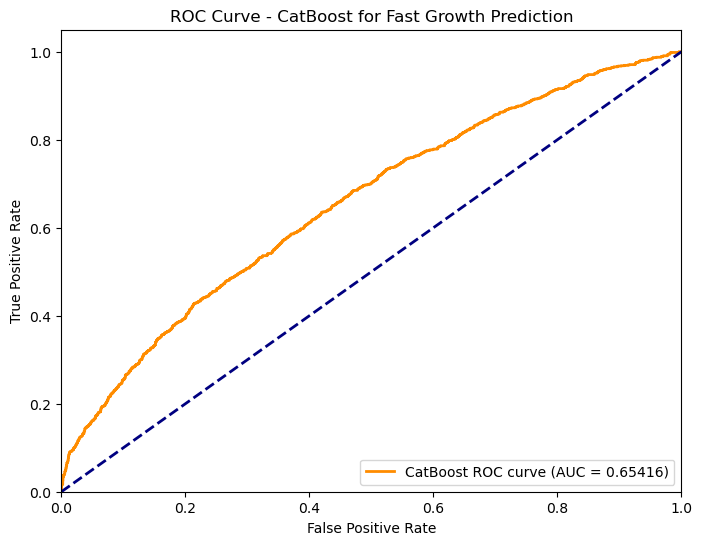

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.98      0.83      2795
           1       0.68      0.10      0.17      1193

    accuracy                           0.72      3988
   macro avg       0.70      0.54      0.50      3988
weighted avg       0.71      0.72      0.63      3988

Holdout RMSE (probabilities): 0.441


In [205]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
cat_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8]
}

# ----------------------------
# 3. Initialize a CatBoostClassifier
# ----------------------------
cat_model = CatBoostClassifier(
    eval_metric='AUC',      # Evaluate by AUC
    random_seed=20250224,   # For reproducibility
    verbose=False           # Set to True if you want iteration logs
)

# ----------------------------
# 4. Set up GridSearchCV
# ----------------------------
cat_gridsearch = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='roc_auc',          # Evaluate with ROC AUC
    refit=True,                 # Refit the best model on the entire training set
    n_jobs=-1                   # Use all available CPU cores
)

# ----------------------------
# 5. Fit the grid search on the training data
# ----------------------------
%time cat_gridsearch.fit(gbvars_train, y_train)

# ----------------------------
# 6. Retrieve Cross-Validation Results
# ----------------------------
cv_results = cat_gridsearch.cv_results_

# Summarize cross-validation scores
cv_auc = cv_results['mean_test_score']
param_settings = cv_results['params']
for ps, auc_val in zip(param_settings, cv_auc):
    print(ps, "CV AUC:", round(auc_val, 5))

print("\nBest Hyperparameters:", cat_gridsearch.best_params_)

# ----------------------------
# 7. Evaluate the Best Model on the Holdout Set
# ----------------------------
best_cat_model = cat_gridsearch.best_estimator_
y_proba_cat = best_cat_model.predict_proba(gbvars_holdout)[:, 1]

# Compute ROC AUC on holdout
cat_auc = roc_auc_score(y_holdout, y_proba_cat)
print("\nCatBoost Holdout ROC AUC:", round(cat_auc, 5))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, y_proba_cat)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='CatBoost ROC curve (AUC = %0.5f)' % roc_auc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost for Fast Growth Prediction')
plt.legend(loc="lower right")
plt.show()

# Print classification report
y_pred_cat = best_cat_model.predict(gbvars_holdout)
print("Classification Report:\n", classification_report(y_holdout, y_pred_cat))

# Compute RMSE on predicted probabilities
cat_rmse = np.sqrt(mean_squared_error(y_holdout, y_proba_cat))
print("Holdout RMSE (probabilities):", round(cat_rmse, 3))

In [206]:
cat_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8]
}

# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(
    eval_metric='AUC',      # Evaluation metric AUC
    random_seed=20250224,   # For reproducibility
    verbose=False           # Set to True for detailed logs
)

# Set up GridSearchCV using a dictionary for scoring
cat_gridsearch = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_grid,
    cv=5,  # 5-fold CV
    scoring={'roc_auc': 'roc_auc', 'neg_brier_score': 'neg_brier_score'},
    refit='roc_auc',  # Refitting based on ROC AUC
    n_jobs=-1
)

# Fit grid search on your training set (here using gbvars_train)
cat_gridsearch.fit(gbvars_train, y_train)

# Retrieve cross-validation results
cv_results_cat = cat_gridsearch.cv_results_

# Get the index corresponding to the best parameter combination
best_index = cat_gridsearch.best_index_

# Create lists for each fold's metrics from the CV results:
auc_folds_cat = [cv_results_cat[f'split{i}_test_roc_auc'][best_index] for i in range(5)]
rmse_folds_cat = [np.sqrt(-cv_results_cat[f'split{i}_test_neg_brier_score'][best_index]) for i in range(5)]


CV_AUC['cat_p'] = auc_folds_cat
CV_RMSE['cat_p'] = rmse_folds_cat

print("Per-fold ROC AUC for best CatBoost model:", CV_AUC['cat_p'])
print("Per-fold RMSE for best CatBoost model:", CV_RMSE['cat_p'])

Per-fold ROC AUC for best CatBoost model: [0.6425227396238125, 0.6487628711933675, 0.6366999492718657, 0.6538080839517312, 0.6517173069443063]
Per-fold RMSE for best CatBoost model: [0.4413885742960373, 0.43891199486175553, 0.44259303073822615, 0.43937123540516476, 0.4404178805045356]


In [207]:
best_thresholds = list()
expected_loss = list()
rfvars_train.columns = rfvars_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
fold = 0
for train_index, test_index in k.split(rfvars_train):
    print(f'{datetime.datetime.now()}: fold {fold}...') 
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    cat_best = CatBoostClassifier(
    random_seed=20250224, 
    iterations=100,        # similar to n_estimators for boosting
    learning_rate=0.1,     # adjust as needed
    depth=6,               # adjust as needed
    verbose=False
    )
    
    cat_best_fold = cat_best.fit(X_fold_train, y_fold_train)
    pred_fold = cat_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

2025-03-09 21:36:45.352886: fold 0...
2025-03-09 21:36:45.883442: fold 1...
2025-03-09 21:36:46.281493: fold 2...
2025-03-09 21:36:46.705835: fold 3...
2025-03-09 21:36:47.109222: fold 4...


In [208]:
for f, t in enumerate(best_thresholds):
    print(f'Fold: {f}, best threshold: {t:,.4f}.')

Fold: 0, best threshold: 0.5096.
Fold: 1, best threshold: 0.6312.
Fold: 2, best threshold: 0.5169.
Fold: 3, best threshold: 0.5095.
Fold: 4, best threshold: 0.5510.


In [209]:
for f, l in enumerate(expected_loss):
    print(f'Fold: {f}, smalles loss: {l:,.4f}.')

Fold: 0, smalles loss: 0.2818.
Fold: 1, smalles loss: 0.2847.
Fold: 2, smalles loss: 0.2869.
Fold: 3, smalles loss: 0.2841.
Fold: 4, smalles loss: 0.2777.


In [210]:
fold5_threshold_cat = best_threshold
fold5_expected_loss_cat = curr_exp_loss

all_coords_cat = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_cat

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,901.0,2289.0,901,2289,3190,inf
1,0.0,1.0,900.0,2289.0,901,2289,3190,0.823938
2,0.0,2.0,899.0,2289.0,901,2289,3190,0.799561
3,1.0,2.0,899.0,2288.0,901,2289,3190,0.746694
4,1.0,7.0,894.0,2288.0,901,2289,3190,0.707196
...,...,...,...,...,...,...,...,...
1221,2275.0,899.0,2.0,14.0,901,2289,3190,0.097104
1222,2275.0,900.0,1.0,14.0,901,2289,3190,0.094215
1223,2276.0,900.0,1.0,13.0,901,2289,3190,0.093600
1224,2276.0,901.0,0.0,13.0,901,2289,3190,0.093305


In [211]:
expected_loss_cv['cat_p'] = np.mean(expected_loss)
best_thresholds_cv['cat_p'] = np.mean(best_thresholds)

In [212]:
cv_rmse_avg = np.mean(CV_RMSE['cat_p'])
cv_auc_avg = np.mean(CV_AUC['cat_p'])
opt_threshold_avg = np.mean(best_thresholds_cv['cat_p'])  # if best_thresholds_cv['gbm_p'] is a list
exp_loss_avg = np.mean(expected_loss_cv['cat_p'])

cat_summary = pd.DataFrame({
    'CV RMSE': [round(cv_rmse_avg, 3)],
    'CV AUC': [round(cv_auc_avg, 3)],
    'Avg of optimal thresholds': [round(opt_threshold_avg, 3)],
    'Threshold for Fold5': [round(best_threshold, 3)],
    'Avg expected loss': [round(exp_loss_avg, 3)],
    'Expected loss for Fold5': [round(curr_exp_loss, 3)]
})

cat_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.441,0.647,0.544,0.551,0.283,0.278


In [213]:
print(nvars.keys())

dict_keys(['X1', 'X2', 'X3', 'X4', 'X5', 'LASSO', 'rf_p'])


In [214]:
nvars_summary = {
    "gbm_p": rfvars.shape[1],
    "xgb_p": rfvars.shape[1],
    "cat_p": rfvars.shape[1]
}

In [227]:
n_models = ["X1", "X2", "X3", "X4", "X5", "LASSO", "rf_p"]
boost_models = ["GBM", "XGBoost", "CatBoost"]

# Combine model names for the summary table.
all_models = n_models + boost_models

# Get number of predictors (adjust keys as needed)
n_predictors = [nvars[model] for model in n_models] + [
    nvars_summary["gbm_p"],
    nvars_summary["xgb_p"],
    nvars_summary["cat_p"]
]

# Aggregate metrics: take the mean of the per-fold arrays.
cv_rmse = [round(np.mean(CV_RMSE[model]), 4) for model in n_models] + [
    round(np.mean(CV_RMSE["gbm_p"]), 4),
    round(np.mean(CV_RMSE["xgb_p"]), 4),
    round(np.mean(CV_RMSE["cat_p"]), 4)
]
cv_auc = [round(np.mean(CV_AUC[model]), 4) for model in n_models] + [
    round(np.mean(CV_AUC["gbm_p"]), 4),
    round(np.mean(CV_AUC["xgb_p"]), 4),
    round(np.mean(CV_AUC["cat_p"]), 4)
]
cv_threshold = [round(np.mean(best_thresholds_cv[model]), 4) for model in n_models] + [
    round(np.mean(best_thresholds_cv["gbm_p"]), 4),
    round(np.mean(best_thresholds_cv["xgb_p"]), 4),
    round(np.mean(best_thresholds_cv["cat_p"]), 4)
]
cv_expected_loss = [round(np.mean(expected_loss_cv[model]), 4) for model in n_models] + [
    round(np.mean(expected_loss_cv["gbm_p"]), 4),
    round(np.mean(expected_loss_cv["xgb_p"]), 4),
    round(np.mean(expected_loss_cv["cat_p"]), 4)
]

# Create the summary table DataFrame.
summary_results = pd.DataFrame({
    "Model": all_models,
    "Number of predictors": n_predictors,
    "CV RMSE": cv_rmse,
    "CV AUC": cv_auc,
    "CV threshold": cv_threshold,
    "CV expected Loss": cv_expected_loss
})

# Format the table for better readability.
summary_results_styled = summary_results.style.format({
    'CV RMSE': '{:.4f}',
    'CV AUC': '{:.4f}',
    'CV threshold': '{:.4f}',
    'CV expected Loss': '{:.4f}'
})

# If you're running in a Jupyter Notebook, ensure the output is rendered:
display(summary_results_styled)

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.4524,0.5526,inf,0.2906
1,X2,18,0.4482,0.5983,0.5130,0.2893
2,X3,35,0.4471,0.6056,0.5296,0.2887
3,X4,79,0.4452,0.6171,0.5242,0.2861
4,X5,163,0.4458,0.6184,0.5871,0.2876
5,LASSO,107,0.4454,0.6207,0.5681,0.2878
6,rf_p,44,0.4443,0.6239,0.6285,0.2850
7,GBM,44,0.4415,0.6406,0.5831,0.2849
8,XGBoost,44,0.4415,0.6402,0.7880,0.2873
9,CatBoost,44,0.4405,0.6467,0.5436,0.2831


## Best result Catboost

### Model testing

In [266]:
best_rf_model = RandomForestClassifier(random_state=20250224, n_estimators=100)
best_rf_model.fit(rfvars_train, y_train)

# Fit a Gradient Boosting model
best_gbm_model = GradientBoostingClassifier(random_state=20250224, n_estimators=100)
best_gbm_model.fit(gbvars_train, y_train)

# Fit an XGBoost model
best_xgb_model = xgb.XGBClassifier(random_state=20250224, n_estimators=100, use_label_encoder=False, eval_metric='auc')
best_xgb_model.fit(xgbvars_train, y_train)

# Fit a CatBoost model
best_cat_model = CatBoostClassifier(random_seed=20250224, iterations=100, verbose=False)
best_cat_model.fit(gbvars_train, y_train)

# For LASSO (logit model), assume you already have it in logit_models["LASSO"]

# Now, create your dictionary of fitted models:
model_objs = {
    "LASSO": logit_models["LASSO"],  # already fitted earlier
    "rf_p": best_rf_model,           # our fitted RF model
    "gbm_p": best_gbm_model,         # our fitted GBM model
    "xgb_p": best_xgb_model,         # our fitted XGBoost model
    "cat_p": best_cat_model          # our fitted CatBoost model
}

# And define the holdout feature sets accordingly:
holdout_features = {
    "LASSO": normalized_logitvars_holdout,
    "rf_p": rfvars_holdout,
    "gbm_p": gbvars_holdout,
    "xgb_p": xgbvars_holdout,
    "cat_p": gbvars_holdout  # using gbvars_holdout for CatBoost as well
}